# Spotify

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
import math
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [46]:
sdf = spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("./data/Spotify-2000.csv")
sdf.show(1 , truncate=False , vertical=True)

-RECORD 0---------------------------------
 Index                  | 1               
 Title                  | Sunrise         
 Artist                 | Norah Jones     
 Top Genre              | adult standards 
 Year                   | 2004            
 Beats Per Minute (BPM) | 157             
 Energy                 | 30              
 Danceability           | 53              
 Loudness (dB)          | -14             
 Liveness               | 11              
 Valence                | 68              
 Length (Duration)      | 201             
 Acousticness           | 94              
 Speechiness            | 3               
 Popularity             | 71              
only showing top 1 row



## Columns flush

In [4]:
sdf = sdf.drop("Title").drop("Year").drop("Year").drop("Index").drop("Artist").drop("Top Genre")
sdf = sdf.withColumn('Length (Duration)',col('Length (Duration)').cast(IntegerType()))

In [5]:
sdf.cache()

DataFrame[Beats Per Minute (BPM): int, Energy: int, Danceability: int, Loudness (dB): int, Liveness: int, Valence: int, Length (Duration): int, Acousticness: int, Speechiness: int, Popularity: int]

In [6]:
sdf.is_cached

True

In [7]:
sdf.printSchema()

root
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



## Data exploration

In [8]:
sdf = sdf.na.drop()

In [9]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                     0|     0|           0|            0|       0|      0|                0|           0|          0|         0|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+



#### Scatter Matrix

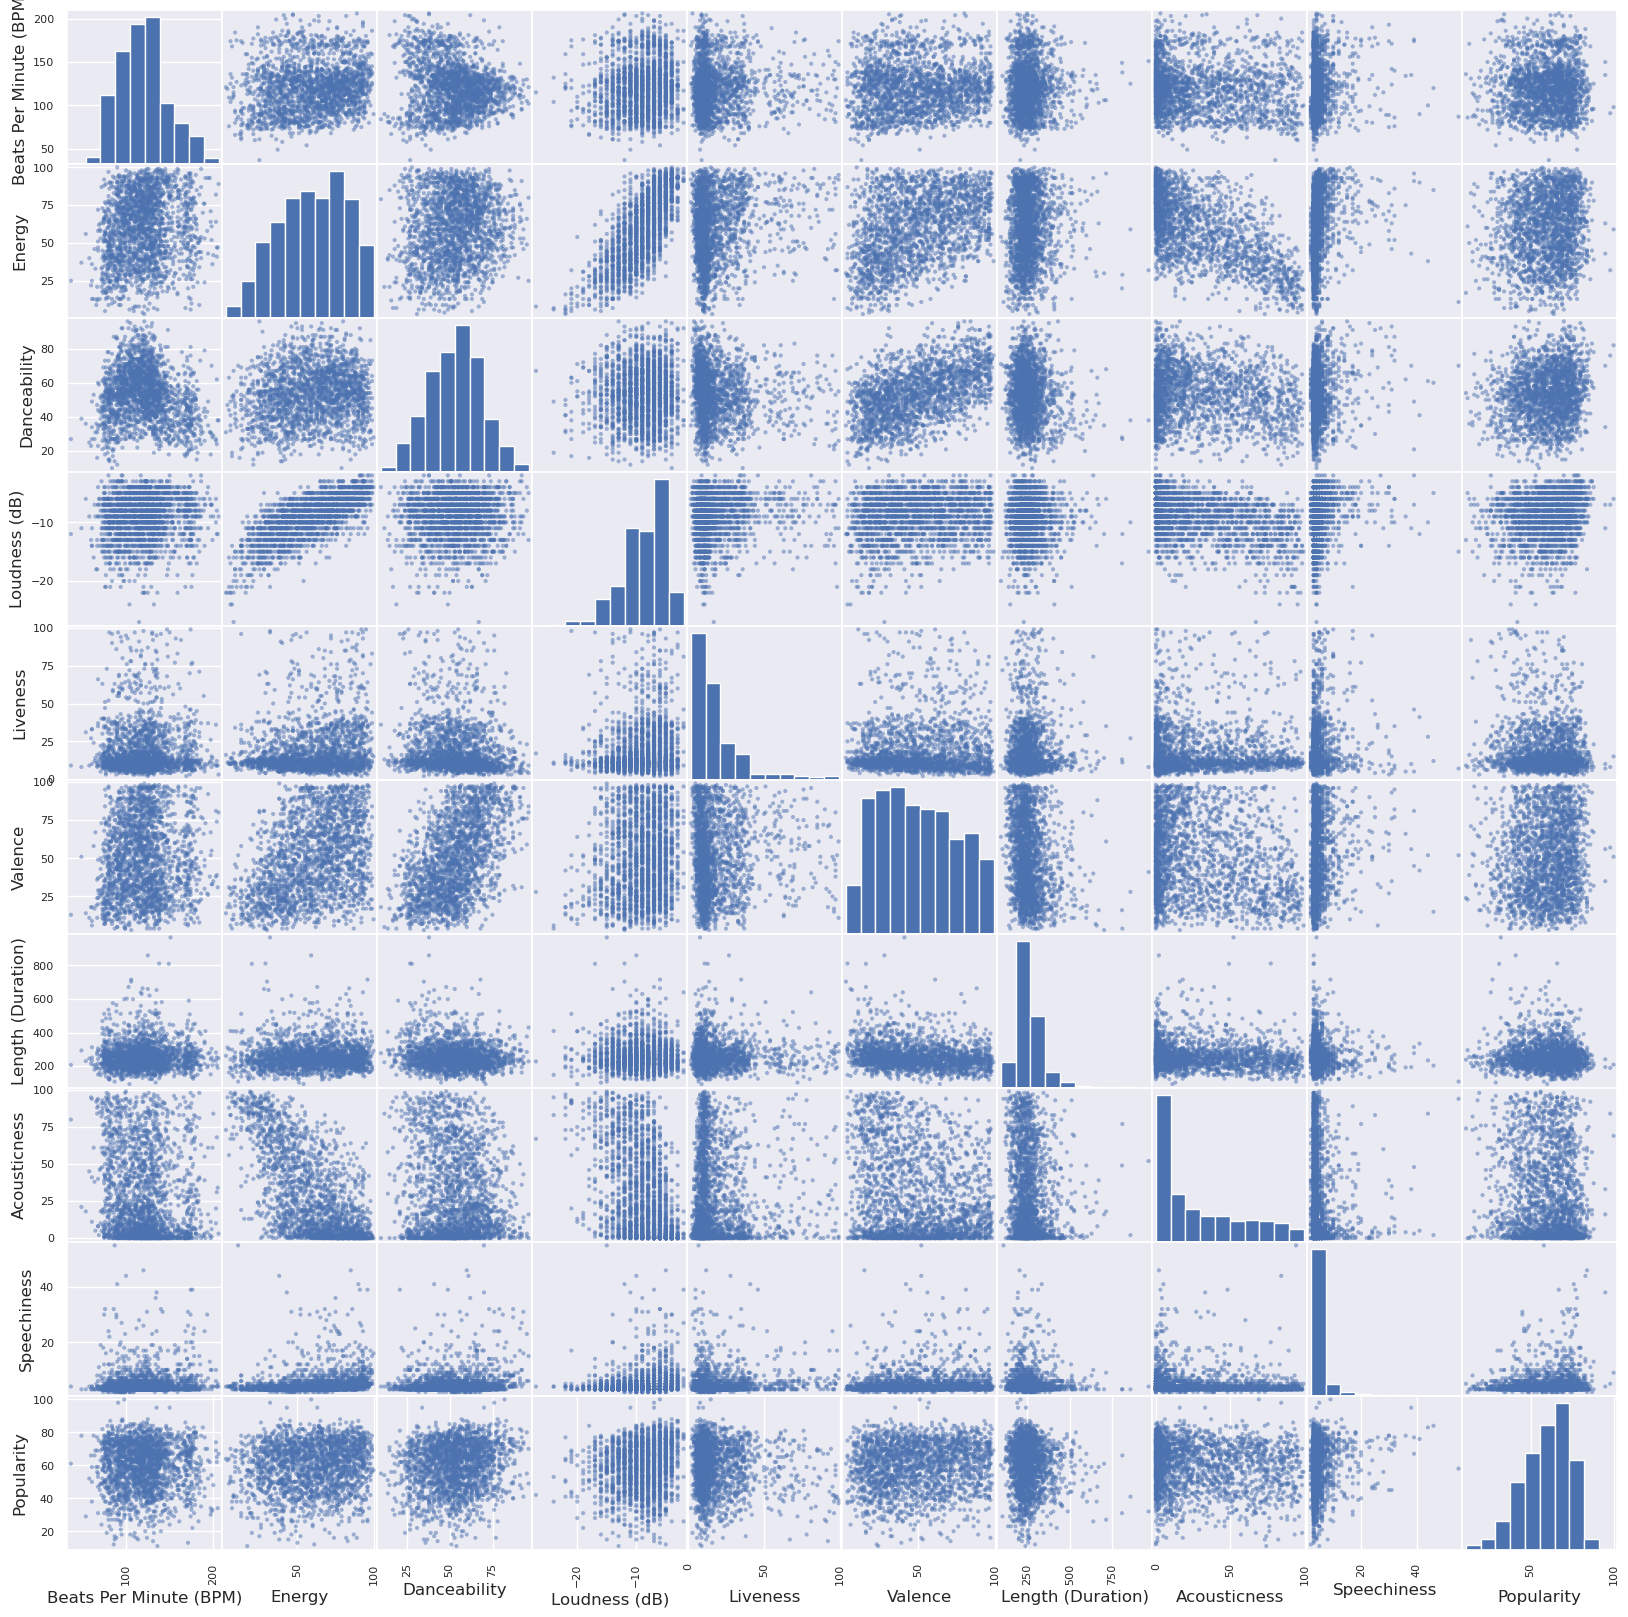

In [10]:
pandasSdf = sdf.toPandas()
scatterMatrix = scatter_matrix(pandasSdf,figsize=(20,20))

# Notre target est la colonne "Popularity"
# Nous avons choisi de l'utiliser en temps qu'axe Y pour étudier l'impact des autres colonnes sur la "Popularity"


### Features Heatmap

<AxesSubplot: >

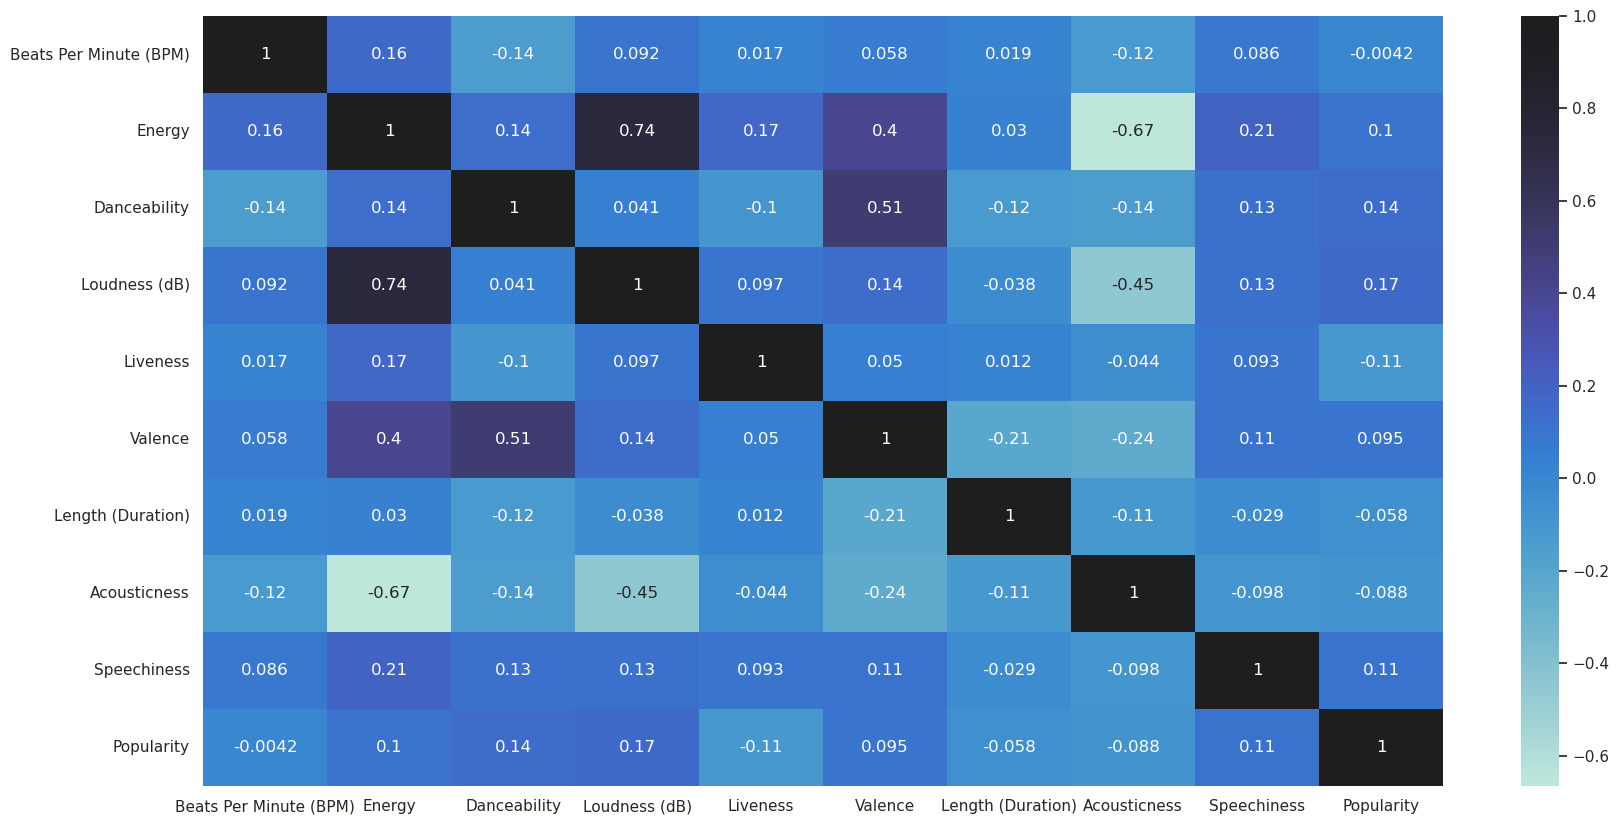

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(sdf.toPandas().corr(),annot = True,center=1)

## Describe

In [12]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_num = sdf.select([col[0] for col in sdf.dtypes if col[1] != 'string'])
col_num.show()

feature_numeric = ['Beats Per Minute (BPM)', 'Energy', 'Danceability',  'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness']

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [45]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_cat = sdf.select([col[0] for col in sdf.dtypes if col[1] == 'string'])

In [14]:
feature_cat = []
feature_cat_indexed = [col+'_indexed' for col in feature_cat]

# Define target : Popularity

In [15]:
labelCol = 'Popularity'

In [16]:
feature_cat_encoded = [col +'_encoded' for col in feature_cat_indexed]

## StringIndexer

In [18]:
#indexer_feature = StringIndexer(inputCols=feature_cat, handleInvalid='skip', outputCols=feature_cat_indexed)
indexer_label = StringIndexer(inputCol=labelCol, handleInvalid='skip', outputCol=labelCol+'_indexed')
#sdf = indexer_feature.fit(sdf).transform(sdf)

## OneHotEncoder

In [19]:
sdf.show()

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [20]:
encoders = OneHotEncoder(dropLast=False, inputCols=feature_cat_indexed, outputCols=feature_cat_encoded)  # handleInvalid='skip',  
#sdf = encoders.fit(sdf).transform(sdf)
#sdf.select(feature_cat_indexed+feature_cat_encoded).show(n=2, truncate=False, vertical=True)

## VectorAssembler

In [21]:
# Vectorizing encoded values
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

assembler = VectorAssembler(inputCols=feature_cat_encoded+feature_numeric, outputCol='features')

#assembler.transform(sdf).select(feature_cat+feature_numeric+feature_cat_encoded+['features']).show(n=2, truncate=False, vertical=True)

## Pipeline LinearRegression

In [22]:
lr = LinearRegression(labelCol='Popularity_indexed', featuresCol='features')

train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

train.cache()
test.cache()
train.show()

lr_model = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [lr]).fit(train)
pred_lr = lr_model.transform(test)
pred_lr.select('prediction', 'Popularity_indexed', 'features').show()
pred_lr.show(n=1, vertical=True, truncate=False)

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                    37|    25|          27|          -12|       9|     13|              207|          80|          4|        61|
|                    49|    37|          39|          -11|       8|     51|              293|          21|          3|        78|
|                    54|    56|          36|           -6|      31|     14|              230|          18|          3|        29|
|                    58|    40|          25|           -9|       9|     11|              245|          45|          4|        52|
|                    60|    22|          23|          -13|      27|     18|              2

In [23]:
squared = lr_model.stages[-1].summary.meanSquaredError

math.sqrt(squared)

15.633055699203593

## RandomForestRegressor

In [24]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

rf= RandomForestRegressor(labelCol='Popularity_indexed', featuresCol='features')

In [25]:
model = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [rf]).fit(train)


In [26]:
pred_rf = model.transform(test)
pred_rf.select('prediction', 'Popularity_indexed', 'features').show()
pred_rf.show(n=1, vertical=True, truncate=False)

+------------------+------------------+--------------------+
|        prediction|Popularity_indexed|            features|
+------------------+------------------+--------------------+
| 22.45664289610932|              42.0|[61.0,13.0,27.0,-...|
|24.219253489441147|              11.0|[61.0,25.0,49.0,-...|
|20.760555883382366|              11.0|[66.0,9.0,36.0,-1...|
|24.337216436997558|              24.0|[67.0,12.0,16.0,-...|
|22.111019153513816|               0.0|[67.0,13.0,47.0,-...|
|21.626234220001216|              21.0|[67.0,21.0,31.0,-...|
|25.895388068638102|              35.0|[68.0,47.0,35.0,-...|
|24.204760298415387|              16.0|[68.0,51.0,33.0,-...|
|21.096251800353738|              36.0|[70.0,13.0,35.0,-...|
|21.555732050969148|              58.0|[72.0,26.0,35.0,-...|
|23.269017325480608|               3.0|[72.0,87.0,43.0,-...|
|22.404538239599912|               8.0|[73.0,26.0,52.0,-...|
|  24.8031644261535|               6.0|[73.0,30.0,36.0,-...|
|22.124685105646833|    

In [28]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Popularity_indexed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred_rf)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[-1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 15.707
RandomForestRegressionModel: uid=RandomForestRegressor_1bad6d1ade5d, numTrees=20, numFeatures=9


In [29]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

## Class columns by score

In [30]:
ExtractFeatureImp(model.stages[-1].featureImportances, pred_rf, "features").head(10)

,idx,name,score
6,6,Length (Duration),0.151001
5,5,Valence,0.148733
1,1,Energy,0.126559
4,4,Liveness,0.109062
0,0,Beats Per Minute (BPM),0.099401
3,3,Loudness (dB),0.097101
8,8,Speechiness,0.095179
7,7,Acousticness,0.092285
2,2,Danceability,0.080679


## Scatter plots for regression Line

<AxesSubplot: xlabel='Beats Per Minute (BPM)', ylabel='prediction'>

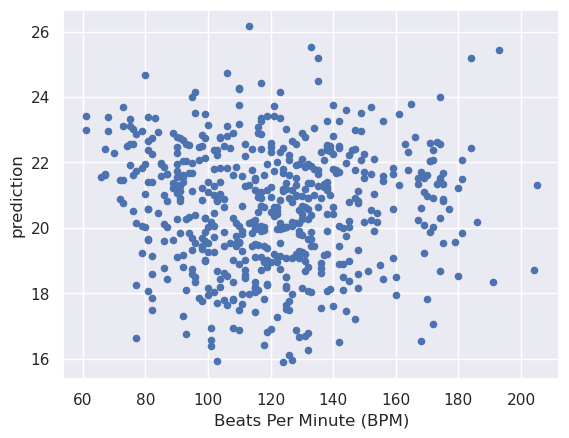

In [31]:
df = pred_lr.toPandas()


df.plot.scatter(x='Beats Per Minute (BPM)', y='prediction')

<AxesSubplot: xlabel='Beats Per Minute (BPM)', ylabel='Popularity'>

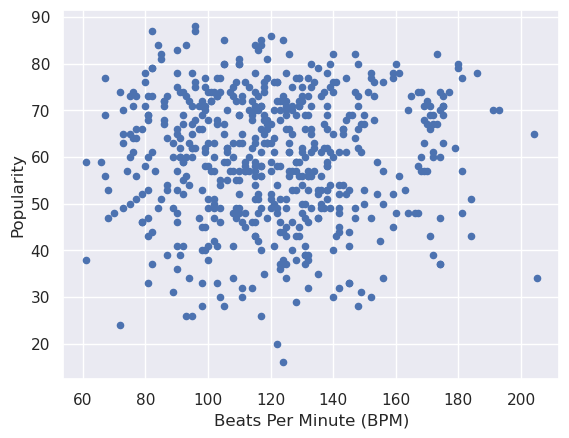

In [32]:
df.plot.scatter(x='Beats Per Minute (BPM)', y='Popularity')

#### D'après le nuage de points suivant, les valeurs ne sont pas linéaires et donc la prédiction n'est pas influencée par l'"Acousticness"

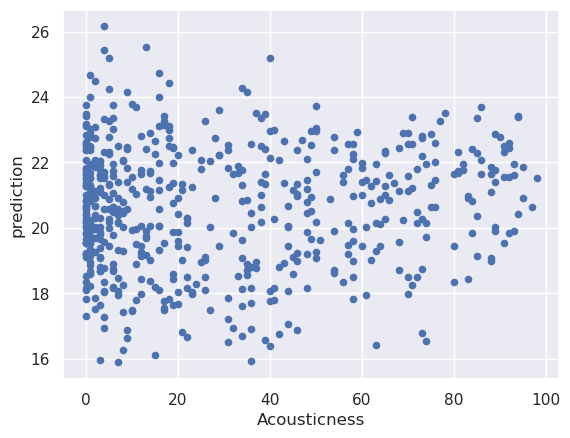

In [47]:
fig = df.plot.scatter(x="Acousticness", y="prediction")

# Clusturing Kmeans

In [49]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(2).setSeed(1)
kmodel = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [kmeans]).fit(train)

predictions = model.transform(test)

In [50]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


# Shows the result.
centers = kmodel.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

kmeans = KMeans(featuresCol="pca_features").setK(2).setSeed(1)

kmodel = Pipeline(stages=[indexer_label]+[encoders]+[assembler]+[pca]+[kmeans]).fit(train)

kpredictions = kmodel.transform(test)

Silhouette with squared euclidean distance = -0.0016209907219971527
Cluster Centers: 
[121.25088339  61.20141343  50.49116608  -9.33568905  19.73498233
  41.28975265 375.7385159   23.07067138   5.37809187]
[119.93755575  59.56199822  53.71454059  -8.83407672  18.74576271
  51.57716325 230.0838537   29.69669938   4.96520963]


In [52]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kpredictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


# Shows the result.
centers = kmodel.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

df = kpredictions.select(['pca_features', 'prediction']).toPandas()
df

Silhouette with squared euclidean distance = 0.6768703799944701
Cluster Centers: 
[226.65972052 -63.47648771]
[378.14804655 -63.12425805]


,pca_features,prediction
0,"[225.70249330974042, 36.48856888496786]",0
1,"[247.56454200075214, -4.14258753136021]",0
2,"[180.70953155156099, 35.00441669873714]",0
3,"[189.03871800708168, 30.871618218139055]",0
4,"[272.7826982481446, 26.048129426846216]",0
...,...,...
571,"[172.4696360064336, -130.16500645326104]",0
572,"[403.70932865692663, -123.18379272336703]",1
573,"[192.26435598195712, -88.176799686488]",0
574,"[244.07015835541998, -55.87206689990852]",0


In [53]:
#Prepare plot of clustering

vectors = pd.DataFrame(df.pca_features.to_list())
df = pd.concat([vectors, df.prediction], axis=1).rename(columns={0: "x", 1: "y"})

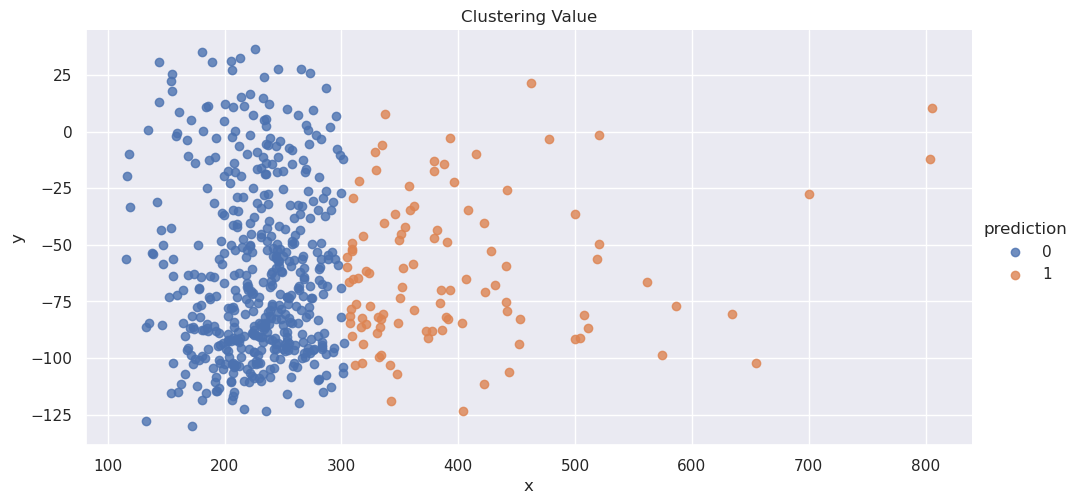

In [57]:
import seaborn

seaborn.lmplot(data = df, x = "x", y = "y", hue = "prediction", 
               fit_reg = False, height = 5, aspect = 2).set(title='Clustering Value')